In [128]:
import os
import itertools
from PIL import Image,ImageEnhance
import pandas as pd
import numpy as np 
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,KFold,cross_val_predict,train_test_split,GridSearchCV
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression,SGDClassifier

In [11]:
#Variables
%matplotlib inline
dataDir = "./data/out/"

In [12]:
files = os.listdir(dataDir)
l1 = []
cols = []
height = None
width = None
for file in files:
    with open(dataDir+file,"rb") as f:
        im = Image.open(dataDir+file)
        enhancer = ImageEnhance.Contrast(im)
        im = enhancer.enhance(4.0)
        label = file.split("_")[1].split(".")[0]
        imArray = np.array(im)
        height,width = imArray.shape
        l1.append([bit for bit in imArray.reshape(imArray.shape[0]*imArray.shape[1])]+[label]) #Todos los bits de la imagen
        
df = pd.DataFrame(l1)
for i in range(height):
    for j in range(width):
        cols.append("%dx%d"%(i,j))
cols.append("Label")
df.columns = cols
    
    

In [152]:

def showImage(df,row,shape):
    data = np.asarray(df.iloc[row,:-1],dtype=np.uint8).reshape(shape)
    img = Image.fromarray(data)
    img.show()
showImage(df,-2,(height,width))
    

In [25]:
stats = df.describe() #estadisticas de las columnas

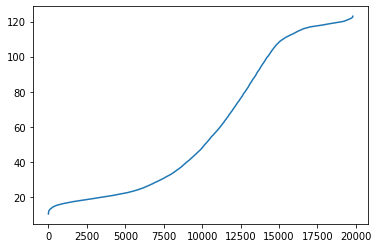

In [26]:
sortedSTD = sorted(list(stats.loc["std",:]))
plt.plot(range(len(sortedSTD)),sortedSTD,"-")

In [161]:
from sklearn.linear_model import Perceptron
acc = []
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
kf = KFold(n_splits=3, shuffle=True)
neigh = Perceptron(tol=1e-5)
#neigh.set_params(**{"n_neighbors":4,"weights":"uniform","n_jobs":8})
for train_index, test_index in kf.split(X):
    xTrain = X.iloc[train_index]
    yTrain = y.iloc[train_index]
    xTest = X.iloc[test_index]
    yTest = y.iloc[test_index]
    neigh.fit(xTrain, yTrain)
    acc.append(accuracy_score(yTest, neigh.predict(xTest), normalize=True, sample_weight=None))
print(np.mean(acc))


0.5872381292714522


In [157]:
def fitHyperparameter(clf,conf,X,y,splits,njobs=multiprocessing.cpu_count()):
    opt = GridSearchCV(clf,conf,cv=splits,n_jobs=njobs)
    search = opt.fit(X, y)
    clf.set_params(**search.best_params_)
    return clf

from sklearn.cluster import KMeans

def testClassifiers(clfs,data,testSize,splits):
    results = {}
    X,y = data.iloc[:,:-1],data.iloc[:,-1]
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=testSize)
    for c in clfs:
        clf,conf = clfs[c]["clf"],clfs[c]["confs"]
        clf = fitHyperparameter(clf,conf,xTrain,yTrain,splits)
        clf.fit(xTrain,yTrain)
        results[c] = {"conf":clf.get_params(),"acc":accuracy_score(yTest, clf.predict(xTest), normalize=True, sample_weight=None)}
        print(results)
    return results

from sklearn import svm
clfs = {
        "KNN":{"clf":KNeighborsClassifier(n_jobs=8),"confs":{"n_neighbors":range(1,10),"weights":("uniform","distance")}},
        "SVM":{"clf":svm.LinearSVC(),"confs":{"kernel":("rbf","linear","sigmoid")}},
        "Logistic Regression":{"clf": LogisticRegression(tol=np.inf,multi_class="multinomial"),"confs":{"penalty":("none","l2"),"solver":("lbfgs","sag","saga"),"max_iter":range(10,100,15)}},
        "SGD":{"clf":SGDClassifier(eta0=0.5,learning_rate='constant',tol=np.inf),"confs":{"eta0":np.linspace(0.1,2,10),"max_iter":range(10,50,10)}}
       }      
print(testClassifiers(clfs,df,0.2,5))


{'SVM': {'conf': {'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}, 'acc': 0.7863636363636364}}


KeyboardInterrupt: 

In [165]:
!pip3 install tensorflow



  Using cached https://files.pythonhosted.org/packages/2c/72/6b3264aa2889b7dde7663464b99587d95cd6a5f3b9b30181f14d78a63e64/tensorflow-2.0.0-cp37-cp37m-macosx_10_11_x86_64.whl


In [168]:
import tensorflow as tf


In [169]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=testSize)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(length, width)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(xTrain, yTrain, epochs=5)

model.evaluate(xTest,  yTest, verbose=2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: dlopen(/usr/local/lib/python3.7/site-packages/tensorf

TypeError: can only concatenate str (not "list") to str